In [1]:
import cv2 as cv
import numpy as np
import pandas as pd
import math
from skimage import img_as_bool
from matplotlib.pylab import imshow, imsave
from skimage.filters import frangi
from matplotlib import pyplot as plt
from skimage.morphology import remove_small_objects, remove_small_holes
from process_image import process_image
from ipyregulartable import RegularTableWidget as table
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from prepare_image import prepare_image
from joblib import dump, load
from IPython.display import display
from imblearn.metrics import sensitivity_specificity_support


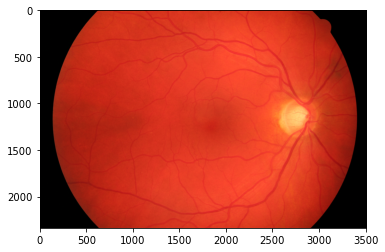

In [2]:
image = cv.imread('data/all/images/07_h.JPG')
imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
#imsave('report/processing/input_image.png', cv.cvtColor(image, cv.COLOR_BGR2RGB))

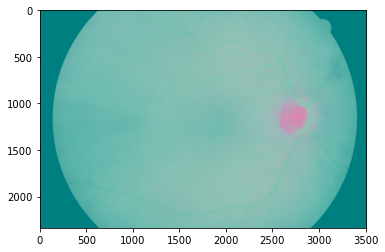

In [3]:
# convert to CIELAB color space and extract lightness
image_lab = cv.cvtColor(image, cv.COLOR_BGR2LAB)
imshow(image_lab)
#imsave('report/processing/lab_image.png', image_lab, cmap='gray')
l, a, b = cv.split(image_lab)


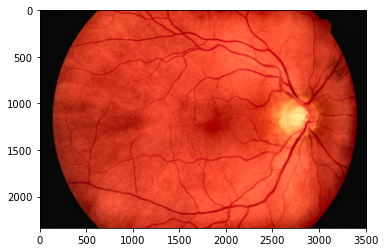

In [4]:
# apply contrast limited adaptive histogram equalization to the L channel
# https://stackoverflow.com/questions/24341114/simple-illumination-correction-in-images-opencv-c
clahe = cv.createCLAHE(clipLimit = 3.0)
merged = cv.merge((clahe.apply(l), a, b))
merged = cv.cvtColor(merged, cv.COLOR_LAB2RGB)
# imshow(clahe.apply(l))
imshow(merged)
#imsave('report/processing/clahe_image.png', merged, cmap='gray')


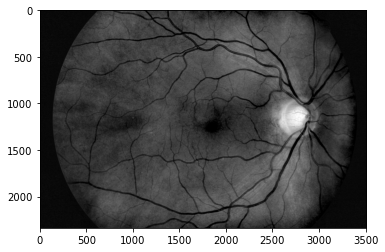

In [5]:
# convert image to BGR and extract green channel (vessels' visibility is the best)
r, g, b = cv.split(merged)
#imsave('report/processing/green_image.png', g, cmap='gray')
imshow(g, cmap = 'gray')

In [6]:
image_frangi = frangi(g)

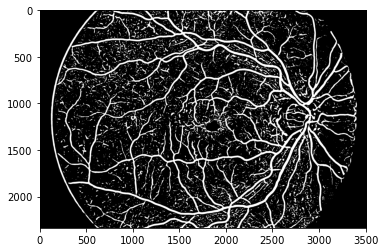

In [7]:
#imsave('report/processing/frangi_image.png', image_frangi, cmap='gray')
ret, thresh = cv.threshold(image_frangi,
                           np.mean(image_frangi) * 0.45, 255, cv.THRESH_BINARY)  #for healthy eyes *0.4 bc of thin tips
thresh = thresh.astype('uint8')
imshow(thresh, cmap = 'gray')
#imsave('report/processing/thresh_image.png', thresh, cmap='gray')



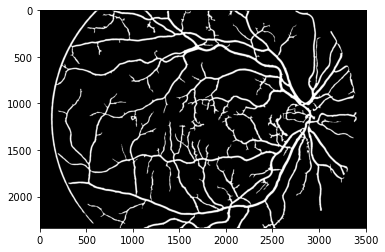

In [8]:
deblobed = thresh > 0
deblobed = remove_small_objects(deblobed, 2500, connectivity = 1)
deblobed = remove_small_holes(deblobed, 900, connectivity = 1)
deblobed = deblobed.astype('uint8') * 255
# (6,6) gives ca 96-98% accuracy and specificity
deblobed = cv.erode(deblobed, cv.getStructuringElement(cv.MORPH_ELLIPSE, (1, 1)))
deblobed = cv.morphologyEx(deblobed, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_ELLIPSE, (12, 12)))
imshow(deblobed, cmap = 'gray')
#imsave('report/processing/deblobed_image.png', deblobed, cmap='gray')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 3503.5, 2335.5, -0.5)

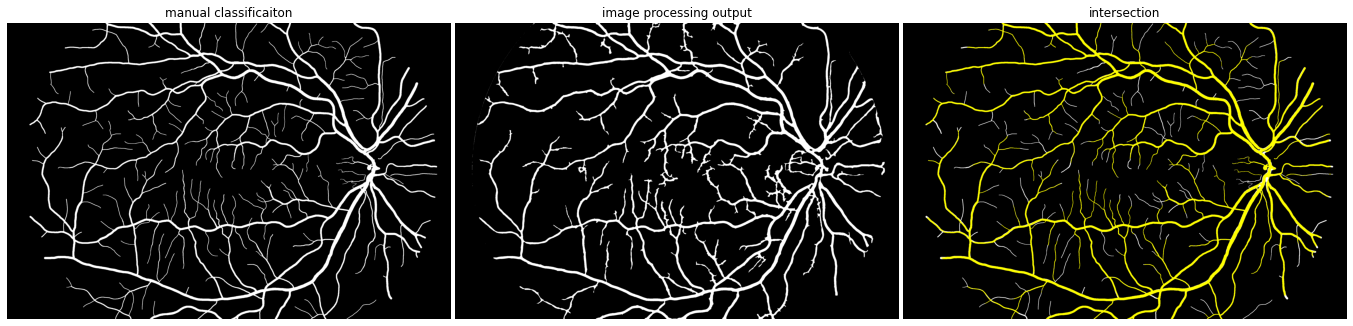

In [12]:
# load the hand-made mask
mask = cv.imread('data/all/manual1/07_h.tif', cv.IMREAD_GRAYSCALE)
cut = cv.imread('data/all/mask/07_h_mask.tif', cv.IMREAD_GRAYSCALE)
cut = cv.bitwise_and(cut, deblobed)

predicted = (cut == 255)
truth = (mask == 255)
true_positive = (predicted & truth)

yellow_mask = np.zeros((*cut.shape, 3))
yellow_mask[truth, :] = 255
yellow_mask[true_positive] = [127, 127, 0]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.subplots_adjust(wspace=0.01, hspace=0.1)
fig.set_size_inches(24, 18)
ax1.imshow(mask, cmap = 'gray')
ax1.set_title('manual classificaiton')
ax2.imshow(cut, cmap = 'gray')
ax2.set_title('image processing output')
ax3.imshow(yellow_mask)
ax3.set_title('intersection')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
#fig.savefig('report/processing/15_h.png')

In [13]:
processed = cut
image_size = processed.shape[0] * processed.shape[1]

mask_binary = mask.copy()
mask_binary[mask_binary < 127] = 0
mask_binary[mask_binary >= 127] = 1

processed_binary = processed.copy()
processed_binary[processed_binary < 127] = 0
processed_binary[processed_binary >= 127] = 1

#TN, FP, FN, TP = confusion_matrix(mask_binary.flatten(), processed_binary.flatten()).ravel()
TP = np.sum(processed_binary[mask_binary == 1])
FP = np.sum(processed_binary[mask_binary == 0])
FN = np.sum(mask_binary[mask_binary == 1]) - np.sum(processed_binary[mask_binary == 1])
TN = image_size - np.sum(processed_binary[mask_binary == 0]) - TP - FN
print(f'TN', TN)
print(f'FP', FP)
print(f'FN', FN)
print(f'TP', TP)


TN 7196786
FP 259545
FN 102626
TP 626387


In [14]:
accuracy = (TP + TN) / (TP + FP + FN + TN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
print(f'accuracy:', accuracy)
print(f'sensitivity : ', sensitivity)
print(f'specificity: ', specificity)


accuracy: 0.9557537227512979
sensitivity :  0.859226104335588
specificity:  0.9651913253314532


In [17]:
accuracies = []
sensitivities = []
specificities = []
weighted_sensitivities = []
weighted_specificities = []

for i in range(1, 16):
    image = cv.imread('data/all/images/' + str(i).zfill(2) + '_h.JPG')
    manual = cv.imread('data/all/manual1/' + str(i).zfill(2) + '_h.tif', cv.IMREAD_GRAYSCALE)
    mask = cv.imread('data/all/mask/' + str(i).zfill(2) + '_h_mask.tif', cv.IMREAD_GRAYSCALE)
    TN, FP, FN, TP, sen, spe = process_image(image, manual, mask)

    accuracy = (TP + TN) / (TP + FP + FN + TN)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    accuracies.append(accuracy)
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    weighted_sensitivities.append(sen)
    weighted_specificities.append(spe)


## Image processing outcome

In [18]:
geometric_means = []
geometric_means = np.sqrt(np.multiply(sensitivities, specificities))
data = [accuracies, sensitivities, specificities, geometric_means, weighted_sensitivities, weighted_specificities]
data = pd.DataFrame(data, index = ['accuracy', 'sensitivity', 'specificity', 'G-mean', 'w_sensitivity', 'w_specificity']).transpose()
data.loc['mean values'] = data.mean()
data.to_csv('image_processing.csv')
dt = table(data)
display(dt)

RegularTableWidget()

## Machine learning - k Nearest Neighbours Classifier

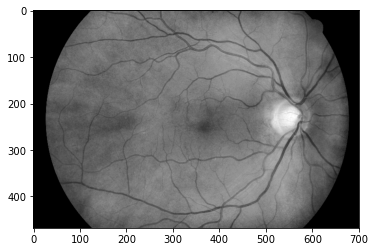

In [15]:
image = cv.imread('data/all/images/07_h.JPG')
mask = cv.imread('data/all/manual1/07_h.tif')
cut = cv.imread('data/all/mask/07_h_mask.tif', cv.IMREAD_GRAYSCALE)

image_lab = cv.cvtColor(image, cv.COLOR_BGR2LAB)
l, a, b = cv.split(image_lab)
clahe = cv.createCLAHE(clipLimit = 2.0)
merged = cv.merge((clahe.apply(l), a, b))
merged = cv.cvtColor(merged, cv.COLOR_LAB2RGB)
merged = cv.cvtColor(merged, cv.COLOR_RGB2GRAY)
tile_size = 5
merged = cv.bitwise_and(merged, cut)

merged = cv.copyMakeBorder(merged,
                           tile_size - merged.shape[0] % tile_size,
                           0,
                           tile_size - merged.shape[1] % tile_size,
                           0,
                           cv.BORDER_CONSTANT,
                           value = [0, 0, 0])

mask = cv.copyMakeBorder(mask,
                         tile_size - mask.shape[0] % tile_size,
                         0,
                         tile_size - mask.shape[1] % tile_size,
                         0,
                         cv.BORDER_CONSTANT,
                         value = [0, 0, 0])

merged = cv.resize(merged, (0, 0), fx = 0.2, fy = 0.2)
mask = cv.resize(mask, (0, 0), fx = 0.2, fy = 0.2)

imshow(merged, cmap = 'gray')


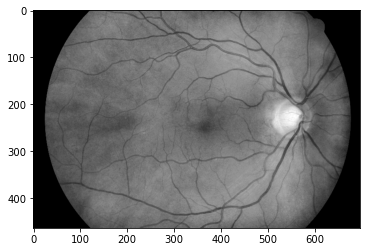

In [16]:
strides = merged.strides * 2
merged_shape = [merged.shape[0] - tile_size + 1, merged.shape[1] - tile_size + 1, tile_size, tile_size]
data = np.lib.stride_tricks.as_strided(merged, shape = merged_shape, strides = strides)
mask = np.lib.stride_tricks.as_strided(mask, shape = merged_shape, strides = strides)
mask = data.reshape(-1, tile_size, tile_size)
data = data.reshape(-1, tile_size, tile_size)
r = np.zeros((data.shape[0]))

for i in range(data.shape[0]):
    r[i] = data[i][2][2]

r = r.reshape((464, 697))
imshow(r, cmap = 'gray')


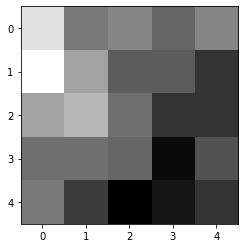

In [17]:
imshow(data[177000], cmap = 'gray')
moments_0 = np.zeros((data.shape[0]))
moments_1 = np.zeros((data.shape[0]))
moments_2 = np.zeros((data.shape[0]))
moments_3 = np.zeros((data.shape[0]))
moments_4 = np.zeros((data.shape[0]))
moments_5 = np.zeros((data.shape[0]))
moments_6 = np.zeros((data.shape[0]))
for i in range(0, data.shape[0], 10):
    m = cv.moments(data[i])
    moments_0[i] = cv.HuMoments(m)[0]
    moments_1[i] = cv.HuMoments(m)[1]
    moments_2[i] = cv.HuMoments(m)[2]
    moments_3[i] = cv.HuMoments(m)[3]
    moments_4[i] = cv.HuMoments(m)[4]
    moments_5[i] = cv.HuMoments(m)[5]
    moments_6[i] = cv.HuMoments(m)[6]


In [19]:
means = np.mean(data, axis = (1, 2))
_vars = np.var(data, axis = (1, 2))


In [18]:
truth = np.zeros((mask.shape[0]), dtype = 'uint8')
tile_coords = np.zeros((mask.shape[0], 2))
for i in range(mask.shape[0]):
    truth[i] = 1 if mask[i][tile_size // 2][tile_size // 2] > 127 else 0


In [20]:
data = [
    means.flatten(),
    _vars.flatten(),
    moments_0.flatten(),
    moments_1.flatten(),
    moments_2.flatten(),
    moments_3.flatten(),
    moments_4.flatten(),
    truth.flatten()
]
knn_data_frame = pd.DataFrame(
    data, index = ['mean', 'var', 'moment 0', 'moment 1', 'moment 2', 'moment 3', 'moment 4', 'truth']).transpose()
knn_data_frame = knn_data_frame[knn_data_frame['mean'] > 0]
dt = table(knn_data_frame)
display(dt)

RegularTableWidget()

In [21]:
X = knn_data_frame.iloc[:, 0:7]
y = knn_data_frame.iloc[:, 7]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.2)
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
kNN = KNeighborsClassifier(n_neighbors = 3, p = 2, metric = 'euclidean')
kNN.fit(X_train, y_train)
dump(kNN, 'kNN_classifier.joblib')


['kNN_classifier.joblib']

In [22]:
y_pred = kNN.predict(X_test)
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [23]:
print(y_pred)
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()
accuracy = (TP + TN) / (TP + FP + FN + TN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
geometric_mean = math.sqrt(specificity * sensitivity)
print(f'accuracy:', accuracy)
print(f'sensitivity : ', sensitivity)
print(f'specificity: ', specificity)
print(f'geometric mean: ', geometric_mean)


[0. 0. 0. ... 0. 0. 0.]
accuracy: 0.9608584494616687
sensitivity :  0.8665635043447208
specificity:  0.9776627564116163
geometric mean:  0.920438408728889


### Classifier testing

In [24]:
kNN_classifier = load('kNN_classifier.joblib')
file_number = '01'
image = cv.imread('data/all/images/' + file_number + '_h.JPG')
mask = cv.imread('data/all/manual1/' + file_number + '_h.tif')
cut = cv.imread('data/all/mask/' + file_number + '_h_mask.tif')


In [25]:
new_image_data_frame = prepare_image(image, mask, cut)

In [26]:
new_X = new_image_data_frame.iloc[:, 0:7]
image_pred = kNN_classifier.predict(new_X)

c:\Users\strze\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 696.5, 463.5, -0.5)

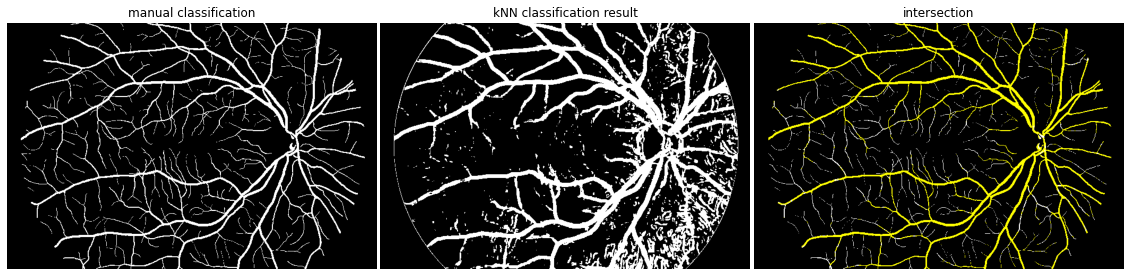

In [27]:
image = cv.imread('data/all/images/' + file_number + '_h.JPG')
mask = cv.imread('data/all/manual1/' + file_number + '_h.tif')
cut = cv.imread('data/all/mask/' + file_number + '_h_mask.tif')
predicted_image_to_display = image_pred.reshape((464, 697)).astype('uint8')
cut = cv.cvtColor(cut, cv.COLOR_BGR2GRAY)
mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)
cut = cv.resize(cut, (predicted_image_to_display.shape[1], predicted_image_to_display.shape[0]))
mask = cv.resize(mask, (predicted_image_to_display.shape[1], predicted_image_to_display.shape[0]))
inversed_image = predicted_image_to_display.copy()
inversed_image[cut == 0] = 1
inversed_image = cv.bitwise_not(inversed_image)
inversed_image = (inversed_image - np.min(inversed_image)) / (np.max(inversed_image) - np.min(inversed_image))

predicted = (inversed_image == 1.0)
truth = (mask == 255)
true_positive = (predicted & truth)

yellow_mask = np.zeros((*cut.shape, 3))
yellow_mask[truth, :] = 255
yellow_mask[true_positive] = [127, 127, 0]

inversed_image = img_as_bool(inversed_image)
mask = img_as_bool(mask)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.subplots_adjust(wspace=0.01, hspace=0.1)
fig.set_size_inches(20, 12)
ax1.imshow(mask, cmap = 'gray')
ax1.set_title('manual classification')
ax2.imshow(inversed_image, cmap = 'gray')
ax2.set_title('kNN classification result')
ax3.imshow(yellow_mask, cmap='gray')
ax3.set_title('intersection')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
#fig.savefig('report/' + file_number + '_h.png')

In [28]:
# depends a lot on neighbours number
TN, FP, FN, TP = confusion_matrix(mask.flatten(), inversed_image.flatten()).ravel()
accuracy = (TP + TN) / (TP + FP + FN + TN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
geometric_mean = math.sqrt(specificity * sensitivity)
print(f'accuracy:', accuracy)
print(f'sensitivity : ', sensitivity)
print(f'specificity: ', specificity)
print(f'geometric mean: ', geometric_mean)

accuracy: 0.8349638846287043
sensitivity :  0.7595271379079803
specificity:  0.8435088226587081
geometric mean:  0.8004172923382519


In [16]:
from machine_learning import get_metrics
df = get_metrics(['01', '04', '12', '09', '15'])

c:\Users\strze\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\strze\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\strze\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\strze\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\strze\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
